# Project Context and Scope

This project is not intended to be a novel academic contribution.  
Instead, it reflects a **realistic, present-day business use case** where speed, interpretability, and deployability matter more than exhaustive experimentation.

As a result, several traditionally rigorous steps (such as extensive hyperparameter tuning, testing multiple model families, or formal statistical proofs) were intentionally skipped.  
These decisions were made to focus on:
- Practical demand forecasting
- Operational relevance
- Clear communication to non-technical stakeholders

The subsequent cells reflect these trade-offs.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
bike_data = pd.read_csv('https://archive.ics.uci.edu/static/public/560/seoul+bike+sharing+demand.zip', encoding='latin1')
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [102]:
bike_data.columns = bike_data.columns.str.replace(' ', '_')
bike_data.columns = bike_data.columns.str.lower()

In [103]:
#bike_data = bike_data.sort_values('date', ascending=False).reset_index()
#bike_data = bike_data.rename(columns={'index': 'rev'}).drop(columns='rev')

### Business Context and Constraints

Bike demand is highly variable and depends on:

- Time of day
- Seasonality
- Weather conditions
- Short-term momentum (recent demand patterns)

The business requirement is practical predictability, not academic novelty.
As a result, several traditionally rigorous steps (e.g., exhaustive hyperparameter tuning or multiple model comparisons) were intentionally skipped in favor of:

- Faster iteration
- Interpretability
- Realistic deployment assumptions

In [104]:
bike_data['date'] = pd.to_datetime(bike_data['date'], errors='coerce')
bike_data['seasons'] = bike_data['seasons'].map({'Spring': 1, 'Summer': 2, 'Autumn': 3, 'Winter': 4})
bike_data['holiday'] = bike_data['holiday'].map({'Holiday': 1, 'No Holiday': 0})
bike_data['functioning_day'] = bike_data['functioning_day'].map({'Yes': 1, 'No': 0})
bike_data

,date,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,4,0,1
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,4,0,1
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,4,0,1
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,4,0,1
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,NaT,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,3,0,1
8756,NaT,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,3,0,1
8757,NaT,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,3,0,1
8758,NaT,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,3,0,1


In [105]:
bike_data = bike_data[~bike_data['date'].isnull()]
bike_data

,date,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,4,0,1
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,4,0,1
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,4,0,1
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,4,0,1
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8323,2018-12-11,1466,19,9.8,46,2.8,1945,-1.2,0.0,0.0,0.0,3,0,1
8324,2018-12-11,1292,20,9.0,48,1.9,1879,-1.4,0.0,0.0,0.0,3,0,1
8325,2018-12-11,1189,21,8.5,50,0.5,1707,-1.3,0.0,0.0,0.0,3,0,1
8326,2018-12-11,1023,22,7.6,55,1.7,1694,-0.8,0.0,0.0,0.0,3,0,1


In [106]:
throwaways = bike_data.drop(columns=['seasons', 'holiday', 'functioning_day'], inplace=True)

/tmp/ipython-input-3848451334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  throwaways = bike_data.drop(columns=['seasons', 'holiday', 'functioning_day'], inplace=True)


In [107]:
future_pred_data = bike_data.copy()
future_pred_data # saved this for the future predictions, seeing as that is the business case (see last 3 cells)

,date,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm)
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8323,2018-12-11,1466,19,9.8,46,2.8,1945,-1.2,0.0,0.0,0.0
8324,2018-12-11,1292,20,9.0,48,1.9,1879,-1.4,0.0,0.0,0.0
8325,2018-12-11,1189,21,8.5,50,0.5,1707,-1.3,0.0,0.0,0.0
8326,2018-12-11,1023,22,7.6,55,1.7,1694,-0.8,0.0,0.0,0.0


### Data Cleaning and Initial Processing

The raw dataset contains a mix of numerical, categorical, and date-based features.

Initial preprocessing steps include:
- Standardizing column names for consistency
- Parsing date values into proper datetime objects
- Encoding categorical variables numerically

Some encoded categorical features are later removed as part of feature selection.  
This decision reflects a preference for **engineered time-based signals** over static categorical indicators, which often duplicate information already captured through cyclical encoding.

In [108]:
days_in_year = bike_data['date'].dt.is_leap_year.map({True: 366, False: 365}) # neurotic check for leap years
date_theta = 2 * np.pi * (bike_data['date'].dt.day_of_year - 1) / days_in_year
hours_theta = 2 * np.pi * bike_data['hour'] / 24

### Time-Based Feature Engineering (Cyclical Encoding)

Time-related variables such as *hour of day* and *day of year* are inherently cyclical.  
For example:
- Hour 23 is closer to hour 0 than to hour 12
- December 31 is closer to January 1 than to July 1

To preserve these relationships, sine and cosine transformations are applied to:
- Day of year
- Hour of day

This allows the model to learn seasonal and daily patterns more naturally than with raw integer values.

In [109]:
bike_data['date_sin'] = np.sin(date_theta)
bike_data['date_cos'] = np.cos(date_theta)
bike_data['hour_sin'] = np.sin(hours_theta)
bike_data['hour_cos'] = np.cos(hours_theta)
bike_data['temp_hour'] = bike_data['temperature(°c)'] / 24
bike_data

/tmp/ipython-input-2771995820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data['date_sin'] = np.sin(date_theta)
/tmp/ipython-input-2771995820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data['date_cos'] = np.cos(date_theta)
/tmp/ipython-input-2771995820.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,date,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),date_sin,date_cos,hour_sin,hour_cos,temp_hour
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0.188227,0.982126,0.000000,1.000000,-0.216667
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0.188227,0.982126,0.258819,0.965926,-0.229167
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0.188227,0.982126,0.500000,0.866025,-0.250000
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0.188227,0.982126,0.707107,0.707107,-0.258333
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0.188227,0.982126,0.866025,0.500000,-0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8323,2018-12-11,1466,19,9.8,46,2.8,1945,-1.2,0.0,0.0,0.0,-0.353676,0.935368,-0.965926,0.258819,0.408333
8324,2018-12-11,1292,20,9.0,48,1.9,1879,-1.4,0.0,0.0,0.0,-0.353676,0.935368,-0.866025,0.500000,0.375000
8325,2018-12-11,1189,21,8.5,50,0.5,1707,-1.3,0.0,0.0,0.0,-0.353676,0.935368,-0.707107,0.707107,0.354167
8326,2018-12-11,1023,22,7.6,55,1.7,1694,-0.8,0.0,0.0,0.0,-0.353676,0.935368,-0.500000,0.866025,0.316667


### Lagged Demand and Trend Features

Bike demand is strongly influenced by **recent usage behavior**.

To capture short-term momentum, several lag-based features are introduced:
- Previous demand values (1, 2, and 3 periods prior)
- Rolling mean to smooth sharp fluctuations
- Rolling standard deviation to capture volatility
- A simple trend indicator measuring recent change

The rolling window sizes are intentionally short.  
This reflects an assumption that **recent demand patterns matter more operationally** than long-term historical averages.
Especially when accounting for things like holidays and weekends, as well as compensating for when demand is quite low;
often after midnight or in more traceable cases towards the end of 2017.

These choices are based on practical intuition as someone who used ride sharing services myself,
and observed ride-hailing behavior, rather than formal statistical validation.

NOTE: I am aware of my bias and how it MAY introduce overfitting

In [110]:
bike_data['rbc_1'] = bike_data['rented_bike_count'].shift(1) # shifts by 1 day
bike_data['rbc_2'] = bike_data['rented_bike_count'].shift(2) # shifts by 2 days
bike_data['rbc_3'] = bike_data['rented_bike_count'].shift(3) # shifts by 3 days
bike_data['rbc_rolling_mean'] = bike_data['rented_bike_count'].shift(1).rolling(window=7).mean() # this is to smoothen the data
bike_data['rbc_rolling_std'] = bike_data['rented_bike_count'].shift(1).rolling(window=7).std() # this is to account for variance in trend, if at all
bike_data['rbc_trend'] = bike_data['rented_bike_count'].rolling(3).apply(lambda x: x.iloc[-1] - x.iloc[0])

/tmp/ipython-input-3582458380.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data['rbc_1'] = bike_data['rented_bike_count'].shift(1) # shifts by 1 day
/tmp/ipython-input-3582458380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_data['rbc_2'] = bike_data['rented_bike_count'].shift(2) # shifts by 2 days
/tmp/ipython-input-3582458380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [111]:
bike_data = bike_data.dropna().reset_index(drop=True)
bike_data_num = bike_data.select_dtypes(include=np.number)

In [112]:
bike_data_num.columns

Index(['rented_bike_count', 'hour', 'temperature(°c)', 'humidity(%)',
       'wind_speed_(m/s)', 'visibility_(10m)', 'dew_point_temperature(°c)',
       'solar_radiation_(mj/m2)', 'rainfall(mm)', 'snowfall_(cm)', 'date_sin',
       'date_cos', 'hour_sin', 'hour_cos', 'temp_hour', 'rbc_1', 'rbc_2',
       'rbc_3', 'rbc_rolling_mean', 'rbc_rolling_std', 'rbc_trend'],
      dtype='object')

In [113]:
feature_col = [
    'hour', 'temperature(°c)','humidity(%)',
    'wind_speed_(m/s)', 'visibility_(10m)', 'dew_point_temperature(°c)',
    'solar_radiation_(mj/m2)', 'rainfall(mm)', 'snowfall_(cm)', 'date_sin', 'date_cos', 'hour_sin',
    'hour_cos', 'temp_hour', 'rbc_1', 'rbc_2', 'rbc_3', 'rbc_rolling_mean',
    'rbc_rolling_std', 'rbc_trend']

target = 'rented_bike_count'

bike_feature = bike_data_num[feature_col]
bike_label = bike_data_num[target]

split = int(len(bike_data_num) * 0.7)

### Train–Test Split Strategy

Data split chronologically (70% train, 30% test)

No shuffling, also this is complementary to Keras' validation_split

*Why this matters:*
This mirrors real-world deployment, where future data is never known at training time.

In [114]:
feature_train = bike_feature.iloc[:split]
feature_test = bike_feature.iloc[split:]

label_train = bike_label.iloc[:split]
label_test = bike_label.iloc[split:]

In [115]:
label_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1035 entries, 2414 to 3448
Series name: rented_bike_count
Non-Null Count  Dtype
--------------  -----
1035 non-null   int64
dtypes: int64(1)
memory usage: 8.2 KB


In [116]:
import tensorflow as tf

SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

### Model Architecture and Design Choices

A feedforward neural network is used for prediction.

Key design considerations:
- Non-linear relationships between weather, time, and demand
- Relatively low architectural complexity for easier deployment
- Use of Mean Absolute Error (MAE), which aligns closely with business impact

The model architecture favors stability and interpretability over maximum theoretical performance.

In [117]:
import keras

def build_model(n_features):
    model = keras.Sequential()
    model.add(keras.layers.Dense(32, activation='gelu', input_shape = (n_features,)))
    #model.add(keras.layers.Dense(64, activation='gelu'))
    model.add(keras.layers.Dense(16, activation='gelu'))
    model.add(keras.layers.Dense(1))

    optimizer = keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mse', 'mae'])

    return model

### Model Training Behavior

Training and validation loss curves are monitored to assess convergence.

Early stopping is applied to:
- Prevent overfitting
- Reduce unnecessary computation
- Maintain generalization performance

The observed loss trends indicate stable learning without significant divergence between training and validation sets.


In [118]:
bike_model = build_model(len(feature_col))
history = bike_model.fit(feature_train, label_train, epochs=500, batch_size=1024, validation_split=0.1, verbose=0, shuffle=False, callbacks=keras.callbacks.EarlyStopping(patience=40))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [119]:
loss, mae1, val_loss, val_mae = history.history['loss'][-1], history.history['mae'][-1], history.history['val_loss'][-1], history.history['val_mae'][-1]
loss, mae1, val_loss, val_mae

(8.082669258117676, 8.082669258117676, 7.427858352661133, 7.427858352661133)

### Why use an R² score?

Firstly because stakeholders find it easier to digest "accuracy" of the model when expressed in percentages (r2_score * 100),
hence its painful (to other practitioners) usage here. It is not the best metric to judge, some may say, but a non-ML person wouldn't know any better
as far as the nerd olympics go on this subject matter, so this is the most tangible abstraction for them.

The high R² score is driven largely by strong temporal structure and short-term demand persistence in the data.
This indicates that bike usage patterns in Seoul are highly regular and predictable at an hourly level when recent demand information is available.

It is also worthy of note that this is only possible due to the lag and rolling features provided. They provide correlation for spotting trends.
As it is with time-series data, if this were to be frequentlyt divergent in trend, it will reflect in the image below - it would be horrific, like a seismic signal.

In [120]:
from sklearn.metrics import r2_score

label_pred = bike_model.predict(feature_test).flatten()
r2 = r2_score(label_test, label_pred)

print('r2 score: ', r2)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
r2 score:  0.9997628927230835


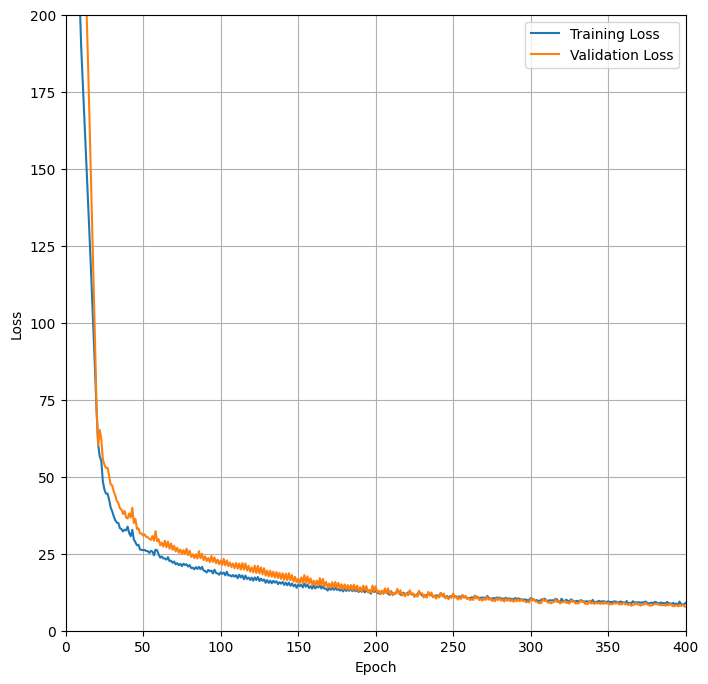

In [121]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlim([0, 400])
plt.ylim([0, 200])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [122]:
results = pd.DataFrame({
    'actual': label_test.values,
    'predicted': label_pred.round()})

results['diff'] = (results['predicted'] - results['actual']).round()

results

,actual,predicted,diff
0,1465,1474.0,9.0
1,1286,1296.0,10.0
2,942,951.0,9.0
3,707,705.0,-2.0
4,455,452.0,-3.0
...,...,...,...
1030,1466,1475.0,9.0
1031,1292,1281.0,-11.0
1032,1189,1198.0,9.0
1033,1023,1020.0,-3.0


# FUTURE PREDICTIONS

From here on out we define new features using existing ones, and use them to predict future hourly demand.
The safest way to do this (I think) is since the `rented_bike_count` for the new is obviously unknown, there will be a shortage in the rolling rbc's.
Consequently, given that all other weather features are unknown as well, it seemed right to use means of each hour's value in correspondence.

I would assume (maybe even argue) that this creates some sort of artiicial trend or relationship between the hours in each day and what possible temperatures they might be,
unbound by season of course, therefore treating each as a separate case. Hour by hour.

This also serves as a decent level of chaos to test the model with, since the `rbc_1` exists in a state of *some* kind of unique randomness from hour 0 to hour 23.

Finally, the end result being a dataframe that consists of upper and lower limits allow for flexibility within the Mean Absolute Error for each hourly prediction.

In [123]:
import datetime as dt
from datetime import timedelta

In [124]:
bike_data_copy = future_pred_data.copy()
bike_data_copy.tail(5)

,date,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm)
8323,2018-12-11,1466,19,9.8,46,2.8,1945,-1.2,0.0,0.0,0.0
8324,2018-12-11,1292,20,9.0,48,1.9,1879,-1.4,0.0,0.0,0.0
8325,2018-12-11,1189,21,8.5,50,0.5,1707,-1.3,0.0,0.0,0.0
8326,2018-12-11,1023,22,7.6,55,1.7,1694,-0.8,0.0,0.0,0.0
8327,2018-12-11,702,23,6.9,60,0.8,1610,-0.3,0.0,0.0,0.0


In [125]:
bike_data_copy['rbc_1'] = bike_data_copy['rented_bike_count'].shift(1)

In [126]:
hour_list = []
date_list = []
temp = []
hum = []
wind = []
vis = []
dew = []
solar = []
rain = []
snow = []
rbc_1 = []


for i in range(24):
    hour_list.append(i)
    date_list.append(bike_data_copy['date'].iloc[-1] + timedelta(1))

    agg_data = bike_data_copy[bike_data_copy['hour'] == i]

    agg_temperature = agg_data['temperature(°c)'].mean()
    temp.append(agg_temperature)

    agg_humidity = agg_data['humidity(%)'].mean()
    hum.append(agg_humidity)

    agg_wind_speed = agg_data['wind_speed_(m/s)'].mean()
    wind.append(agg_wind_speed)

    agg_visibility = agg_data['visibility_(10m)'].mean()
    vis.append(agg_visibility)

    agg_dew_point_temperature = agg_data['dew_point_temperature(°c)'].mean()
    dew.append(agg_dew_point_temperature)

    agg_solar_radiation = agg_data['solar_radiation_(mj/m2)'].mean()
    solar.append(agg_solar_radiation)

    agg_rainfall = agg_data['rainfall(mm)'].mean()
    rain.append(agg_rainfall)

    agg_snowfall = agg_data['snowfall_(cm)'].mean()
    snow.append(agg_snowfall)

    agg_rbc_1 = agg_data['rbc_1'].mean()
    rbc_1.append(agg_rbc_1)

feats = pd.DataFrame({'hour': hour_list, 'date': date_list,
                      'temperature(°c)': temp, 'humidity(%)': hum,
                      'wind_speed_(m/s)': wind, 'visibility_(10m)': vis,
                      'dew_point_temperature(°c)': dew, 'solar_radiation_(mj/m2)': solar,
                      'rainfall(mm)': rain, 'snowfall_(cm)': snow,
                      'rbc_1': rbc_1})

bike_data_copy = pd.concat([bike_data_copy, feats], ignore_index=True)

In [127]:
bike_data_copy['rbc_2'] = bike_data_copy['rbc_1'].shift(1)
bike_data_copy['rbc_3'] = bike_data_copy['rbc_1'].shift(2)
bike_data_copy['rbc_rolling_mean'] = bike_data_copy['rbc_1'].shift(1).rolling(window=7).mean()
bike_data_copy['rbc_rolling_std'] = bike_data_copy['rbc_1'].shift(1).rolling(window=7).std()
bike_data_copy['rbc_trend'] = bike_data_copy['rbc_1'].rolling(3).apply(lambda x: x.iloc[-1] - x.iloc[0])

#bike_data_copy = bike_data_copy.dropna().reset_index(drop=True)
#bike_data_copy = bike_data_copy.select_dtypes(include=np.number)

In [128]:
bike_data_copy.fillna(np.nan, inplace=True)

In [129]:
bike_data_copy.tail(24)

,date,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),rbc_1,rbc_2,rbc_3,rbc_rolling_mean,rbc_rolling_std,rbc_trend
3456,2018-12-12,NaN,0,10.938889,66.166667,1.470833,1487.409722,4.578472,0.000000,0.296528,0.028472,626.503497,1023.000000,1189.000000,1379.571429,325.234714,-562.496503
3457,2018-12-12,NaN,1,10.602778,67.159722,1.318056,1478.326389,4.490972,0.000000,0.097222,0.031944,516.805556,626.503497,1023.000000,1298.643357,432.265863,-506.194444
3458,2018-12-12,NaN,2,10.249306,68.833333,1.278472,1449.659722,4.517361,0.000000,0.142361,0.032639,397.909722,516.805556,626.503497,1162.187007,511.859051,-228.593774
3459,2018-12-12,NaN,3,9.941667,69.666667,1.227778,1432.625000,4.407639,0.000000,0.186806,0.032639,279.875000,397.909722,516.805556,930.174111,416.339130,-236.930556
3460,2018-12-12,NaN,4,9.668056,69.951389,1.277778,1402.375000,4.201389,0.000000,0.090972,0.033333,191.493056,279.875000,397.909722,760.727682,403.076612,-206.416667
3461,2018-12-12,NaN,5,9.438194,70.784722,1.236806,1394.208333,4.164583,0.000000,0.084028,0.038889,126.631944,191.493056,279.875000,603.512404,374.963512,-153.243056
3462,2018-12-12,NaN,6,9.213889,70.909722,1.238889,1402.083333,3.954167,0.005903,0.186806,0.052778,135.284722,126.631944,191.493056,451.745539,307.401147,-56.208333
3463,2018-12-12,NaN,7,9.185417,70.236111,1.314583,1406.340278,3.785417,0.092500,0.118056,0.059722,284.263889,135.284722,126.631944,324.929071,195.026350,157.631944
3464,2018-12-12,NaN,8,9.704861,66.986111,1.413889,1412.770833,3.525694,0.353264,0.132639,0.058333,584.402778,284.263889,135.284722,276.037698,142.703435,449.118056
3465,2018-12-12,NaN,9,10.840278,61.243056,1.615972,1420.250000,3.229861,0.782292,0.204861,0.059028,969.118056,584.402778,284.263889,285.694444,162.610329,684.854167


In [130]:
day_in_year = bike_data_copy['date'].dt.is_leap_year.map({True: 366, False: 365}) # neurotic check for leap years
dt_theta = 2 * np.pi * (bike_data_copy['date'].dt.day_of_year - 1) / day_in_year
hr_theta = 2 * np.pi * bike_data_copy['hour'] / 24

bike_data_copy['date_sin'] = np.sin(dt_theta)
bike_data_copy['date_cos'] = np.cos(dt_theta)
bike_data_copy['hour_sin'] = np.sin(hr_theta)
bike_data_copy['hour_cos'] = np.cos(hr_theta)
bike_data_copy['temp_hour'] = bike_data_copy['temperature(°c)'] / 24

In [131]:
bike_data_copy.tail(24)

,date,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),...,rbc_2,rbc_3,rbc_rolling_mean,rbc_rolling_std,rbc_trend,date_sin,date_cos,hour_sin,hour_cos,temp_hour
3456,2018-12-12,NaN,0,10.938889,66.166667,1.470833,1487.409722,4.578472,0.000000,0.296528,...,1023.000000,1189.000000,1379.571429,325.234714,-562.496503,-0.337523,0.941317,0.000000e+00,1.000000e+00,0.455787
3457,2018-12-12,NaN,1,10.602778,67.159722,1.318056,1478.326389,4.490972,0.000000,0.097222,...,626.503497,1023.000000,1298.643357,432.265863,-506.194444,-0.337523,0.941317,2.588190e-01,9.659258e-01,0.441782
3458,2018-12-12,NaN,2,10.249306,68.833333,1.278472,1449.659722,4.517361,0.000000,0.142361,...,516.805556,626.503497,1162.187007,511.859051,-228.593774,-0.337523,0.941317,5.000000e-01,8.660254e-01,0.427054
3459,2018-12-12,NaN,3,9.941667,69.666667,1.227778,1432.625000,4.407639,0.000000,0.186806,...,397.909722,516.805556,930.174111,416.339130,-236.930556,-0.337523,0.941317,7.071068e-01,7.071068e-01,0.414236
3460,2018-12-12,NaN,4,9.668056,69.951389,1.277778,1402.375000,4.201389,0.000000,0.090972,...,279.875000,397.909722,760.727682,403.076612,-206.416667,-0.337523,0.941317,8.660254e-01,5.000000e-01,0.402836
3461,2018-12-12,NaN,5,9.438194,70.784722,1.236806,1394.208333,4.164583,0.000000,0.084028,...,191.493056,279.875000,603.512404,374.963512,-153.243056,-0.337523,0.941317,9.659258e-01,2.588190e-01,0.393258
3462,2018-12-12,NaN,6,9.213889,70.909722,1.238889,1402.083333,3.954167,0.005903,0.186806,...,126.631944,191.493056,451.745539,307.401147,-56.208333,-0.337523,0.941317,1.000000e+00,6.123234e-17,0.383912
3463,2018-12-12,NaN,7,9.185417,70.236111,1.314583,1406.340278,3.785417,0.092500,0.118056,...,135.284722,126.631944,324.929071,195.026350,157.631944,-0.337523,0.941317,9.659258e-01,-2.588190e-01,0.382726
3464,2018-12-12,NaN,8,9.704861,66.986111,1.413889,1412.770833,3.525694,0.353264,0.132639,...,284.263889,135.284722,276.037698,142.703435,449.118056,-0.337523,0.941317,8.660254e-01,-5.000000e-01,0.404369
3465,2018-12-12,NaN,9,10.840278,61.243056,1.615972,1420.250000,3.229861,0.782292,0.204861,...,584.402778,284.263889,285.694444,162.610329,684.854167,-0.337523,0.941317,7.071068e-01,-7.071068e-01,0.451678


In [132]:
pred_data = bike_data_copy[feature_col][-24:]
pred_data

,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),date_sin,date_cos,hour_sin,hour_cos,temp_hour,rbc_1,rbc_2,rbc_3,rbc_rolling_mean,rbc_rolling_std,rbc_trend
3456,0,10.938889,66.166667,1.470833,1487.409722,4.578472,0.000000,0.296528,0.028472,-0.337523,0.941317,0.000000e+00,1.000000e+00,0.455787,626.503497,1023.000000,1189.000000,1379.571429,325.234714,-562.496503
3457,1,10.602778,67.159722,1.318056,1478.326389,4.490972,0.000000,0.097222,0.031944,-0.337523,0.941317,2.588190e-01,9.659258e-01,0.441782,516.805556,626.503497,1023.000000,1298.643357,432.265863,-506.194444
3458,2,10.249306,68.833333,1.278472,1449.659722,4.517361,0.000000,0.142361,0.032639,-0.337523,0.941317,5.000000e-01,8.660254e-01,0.427054,397.909722,516.805556,626.503497,1162.187007,511.859051,-228.593774
3459,3,9.941667,69.666667,1.227778,1432.625000,4.407639,0.000000,0.186806,0.032639,-0.337523,0.941317,7.071068e-01,7.071068e-01,0.414236,279.875000,397.909722,516.805556,930.174111,416.339130,-236.930556
3460,4,9.668056,69.951389,1.277778,1402.375000,4.201389,0.000000,0.090972,0.033333,-0.337523,0.941317,8.660254e-01,5.000000e-01,0.402836,191.493056,279.875000,397.909722,760.727682,403.076612,-206.416667
3461,5,9.438194,70.784722,1.236806,1394.208333,4.164583,0.000000,0.084028,0.038889,-0.337523,0.941317,9.659258e-01,2.588190e-01,0.393258,126.631944,191.493056,279.875000,603.512404,374.963512,-153.243056
3462,6,9.213889,70.909722,1.238889,1402.083333,3.954167,0.005903,0.186806,0.052778,-0.337523,0.941317,1.000000e+00,6.123234e-17,0.383912,135.284722,126.631944,191.493056,451.745539,307.401147,-56.208333
3463,7,9.185417,70.236111,1.314583,1406.340278,3.785417,0.092500,0.118056,0.059722,-0.337523,0.941317,9.659258e-01,-2.588190e-01,0.382726,284.263889,135.284722,126.631944,324.929071,195.026350,157.631944
3464,8,9.704861,66.986111,1.413889,1412.770833,3.525694,0.353264,0.132639,0.058333,-0.337523,0.941317,8.660254e-01,-5.000000e-01,0.404369,584.402778,284.263889,135.284722,276.037698,142.703435,449.118056
3465,9,10.840278,61.243056,1.615972,1420.250000,3.229861,0.782292,0.204861,0.059028,-0.337523,0.941317,7.071068e-01,-7.071068e-01,0.451678,969.118056,584.402778,284.263889,285.694444,162.610329,684.854167


In [133]:
import tensorflow as tf

SEED_VAL = 24

np.random.seed(SEED_VAL)
tf.random.set_seed(SEED_VAL)

In [134]:
feature_test

,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),date_sin,date_cos,hour_sin,hour_cos,temp_hour,rbc_1,rbc_2,rbc_3,rbc_rolling_mean,rbc_rolling_std,rbc_trend
2414,21,29.3,75,3.6,1674,24.4,0.0,0.0,0.0,0.816538,-0.577292,-0.707107,0.707107,1.220833,1524.0,1411.0,1247.0,1047.000000,350.218027,54.0
2415,22,29.1,77,3.0,1559,24.6,0.0,0.0,0.0,0.816538,-0.577292,-0.500000,0.866025,1.212500,1465.0,1524.0,1411.0,1165.000000,328.305752,-238.0
2416,23,28.8,79,1.3,1484,24.7,0.0,0.0,0.0,0.816538,-0.577292,-0.258819,0.965926,1.200000,1286.0,1465.0,1524.0,1247.000000,261.110449,-523.0
2417,0,28.7,79,2.2,1473,24.6,0.0,0.0,0.0,0.409356,-0.912375,0.000000,1.000000,1.195833,942.0,1286.0,1465.0,1264.714286,229.441143,-579.0
2418,1,28.7,80,1.5,1295,24.8,0.0,0.0,0.0,0.409356,-0.912375,0.258819,0.965926,1.195833,707.0,942.0,1286.0,1226.000000,298.386774,-487.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,19,9.8,46,2.8,1945,-1.2,0.0,0.0,0.0,-0.353676,0.935368,-0.965926,0.258819,0.408333,2022.0,1472.0,1193.0,1204.857143,419.457757,-6.0
3445,20,9.0,48,1.9,1879,-1.4,0.0,0.0,0.0,-0.353676,0.935368,-0.866025,0.500000,0.375000,1466.0,2022.0,1472.0,1287.428571,403.265776,-730.0
3446,21,8.5,50,0.5,1707,-1.3,0.0,0.0,0.0,-0.353676,0.935368,-0.707107,0.707107,0.354167,1292.0,1466.0,2022.0,1345.000000,363.733877,-277.0
3447,22,7.6,55,1.7,1694,-0.8,0.0,0.0,0.0,-0.353676,0.935368,-0.500000,0.866025,0.316667,1189.0,1292.0,1466.0,1388.285714,314.736246,-269.0


In [135]:
next_pred = bike_model.predict(pred_data).flatten().round(0)
hours = np.array(bike_data_copy['hour'].iloc[-24:]).flatten()
pred_results = pd.DataFrame({'predictions': pd.Series(next_pred), 'hour': hours})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [136]:
pred_results

,predictions,hour
0,446.0,0
1,126.0,1
2,290.0,2
3,166.0,3
4,79.0,4
5,43.0,5
6,63.0,6
7,284.0,7
8,725.0,8
9,1249.0,9


In [137]:
pred_results['lower_limit'] = (pred_results['predictions'] - mae1).round(0)
pred_results['upper_limit'] = (pred_results['predictions'] + mae1).round(0)

In [138]:
print(f"{'='*5} Next Day hourly bike demand future predictions {'='*5}")
pred_results

===== Next Day hourly bike demand future predictions =====


,predictions,hour,lower_limit,upper_limit
0,446.0,0,438.0,454.0
1,126.0,1,118.0,134.0
2,290.0,2,282.0,298.0
3,166.0,3,158.0,174.0
4,79.0,4,71.0,87.0
5,43.0,5,35.0,51.0
6,63.0,6,55.0,71.0
7,284.0,7,276.0,292.0
8,725.0,8,717.0,733.0
9,1249.0,9,1241.0,1257.0
